# 1 Dependencies import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.utils import fill_infos

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(294697)

***
# 2 Data import

In [2]:
data = pd.read_csv("datas/sample.csv", index_col=[0], sep=";")

In [3]:
data.shape

(95365, 58)

***
# 3 Overview

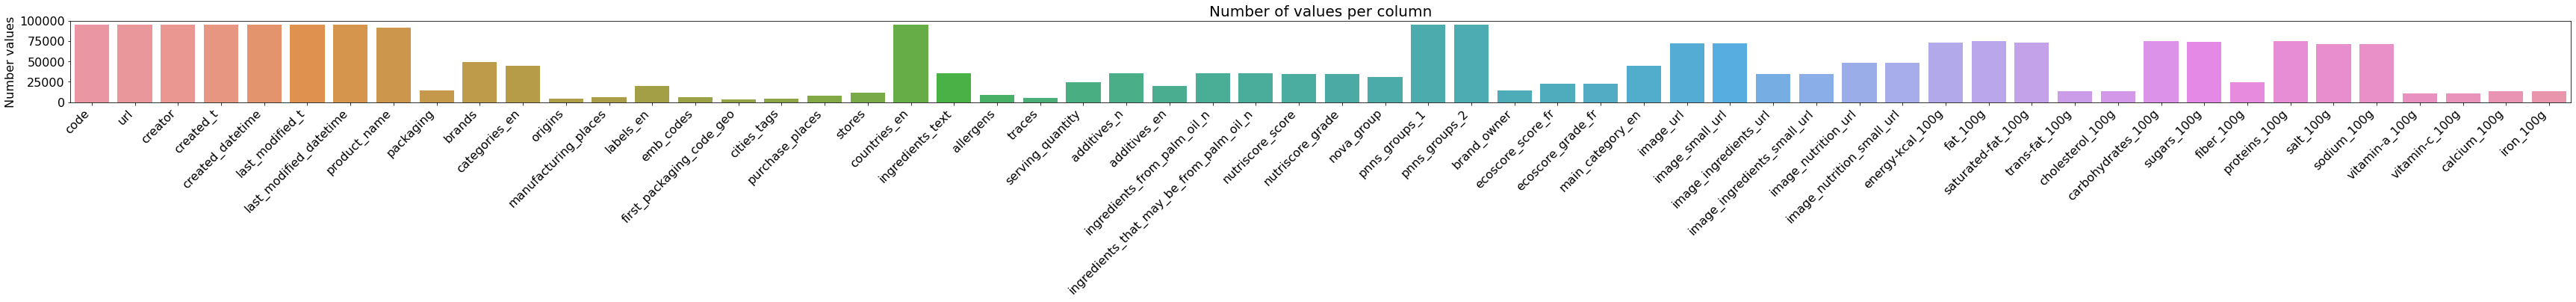

In [4]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data.columns, y=data.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
# 4 Global correlations

In [5]:
corr = data.corr()

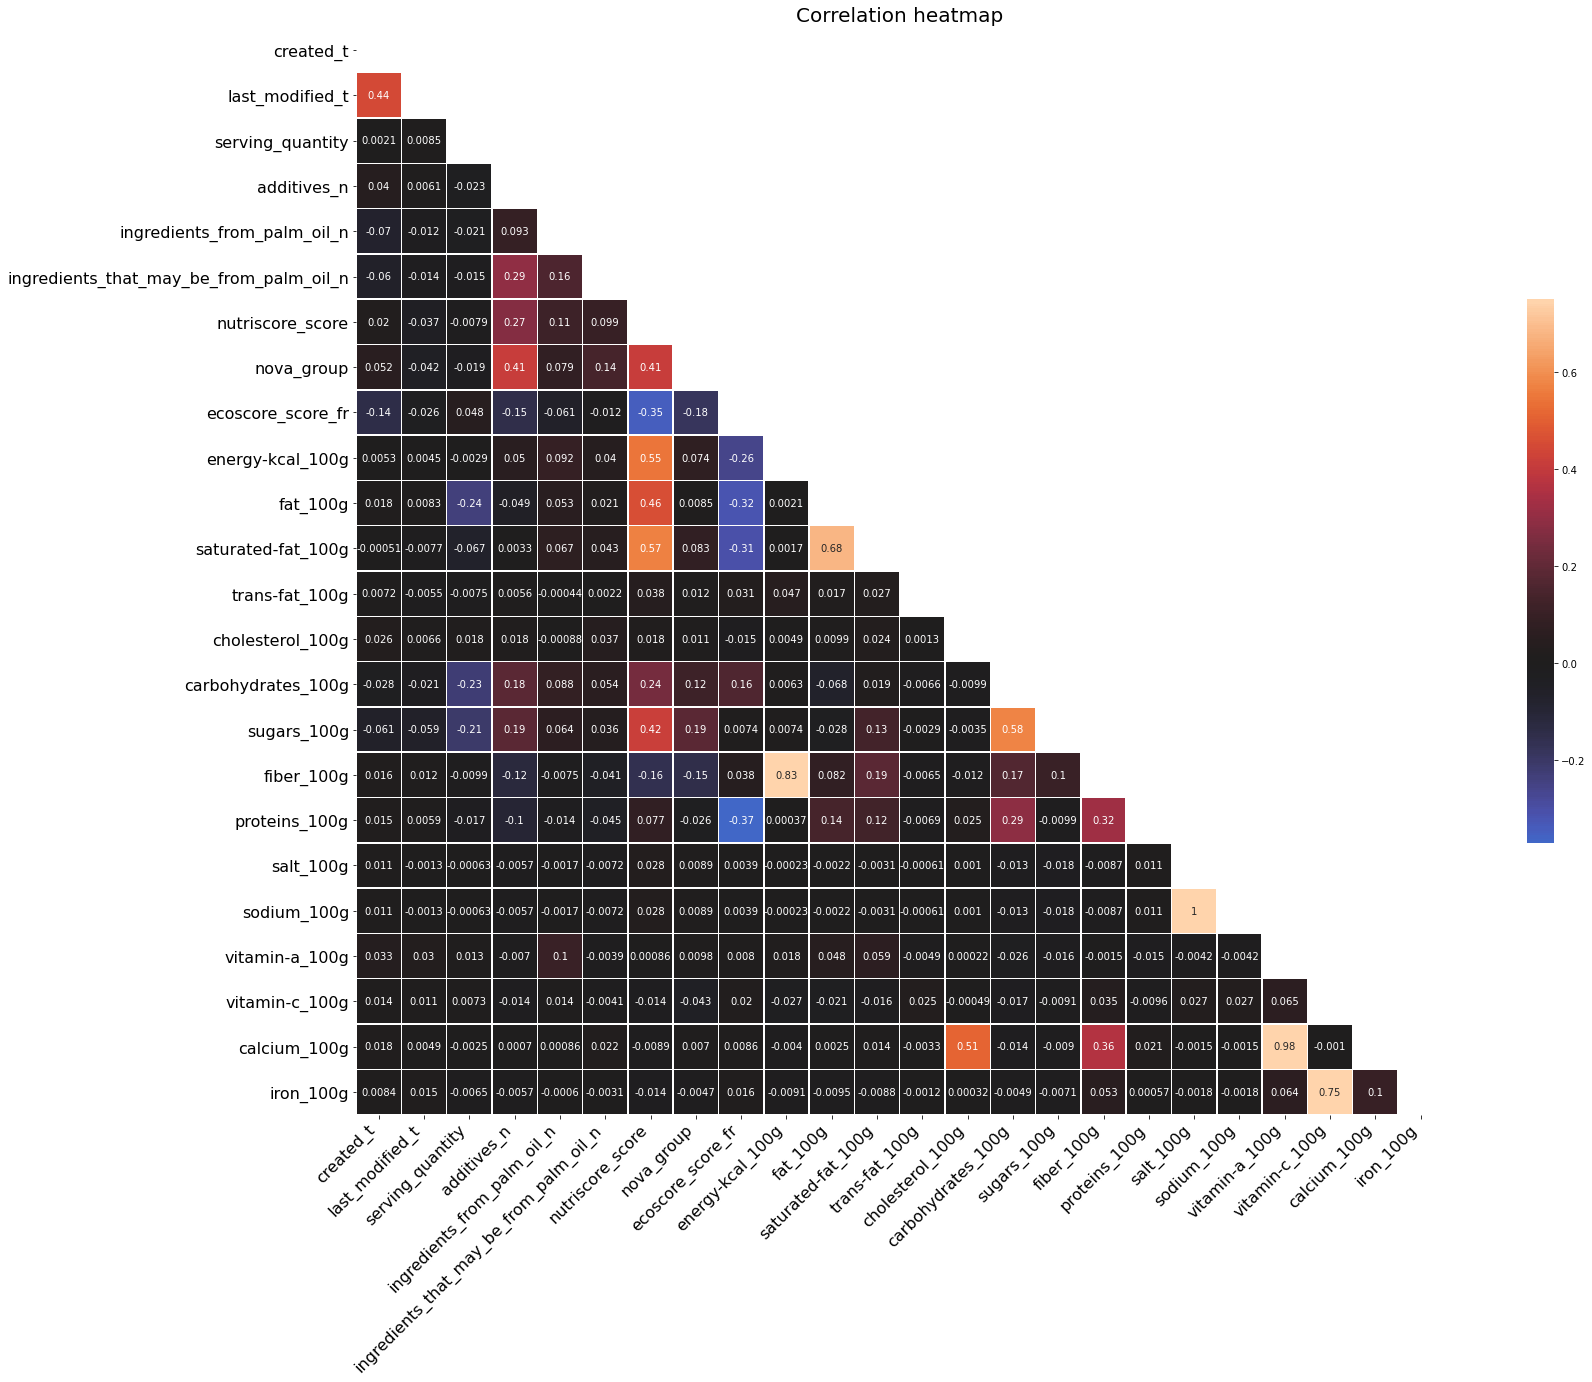

In [6]:
plt.figure(figsize=(30, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(data=corr, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

***
# 5 Nutriscore / Ecoscore correlations

<AxesSubplot:title={'center':'Nutriscore correlations'}, ylabel='nutriscore_score'>

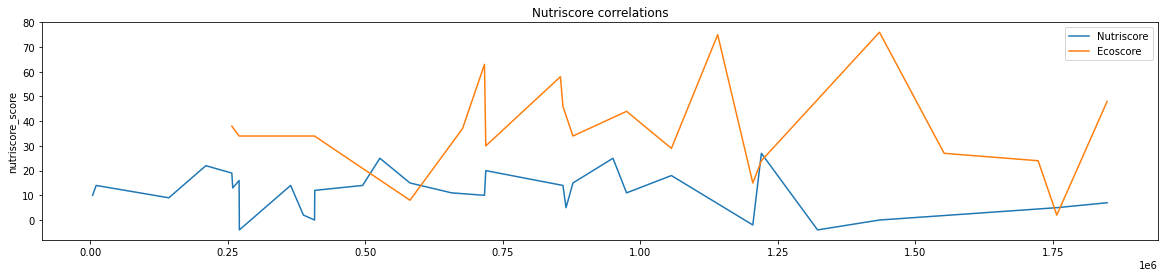

In [7]:
plt.figure(figsize=(20, 4))

plt.title("Nutriscore correlations")

sns.lineplot(y=data.nutriscore_score[::1000], x=data.index[::1000], label="Nutriscore")
sns.lineplot(y=data.ecoscore_score_fr[::1000], x=data.index[::1000], label="Ecoscore")

Nutriscore: the bigger the value, the worst the product is.  
Ecoscore: the bigger the value, the worst the environemental impact is.

## Conclusion:
The worst is a product (high nutriscore), the better it is for the environement (low ecoscore).

***
# 6 Nutriscore / Ecoscore distribution

<Figure size 720x432 with 0 Axes>

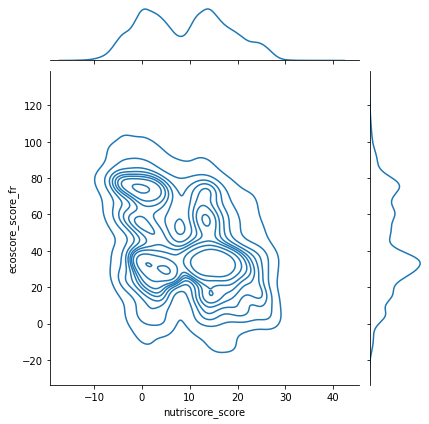

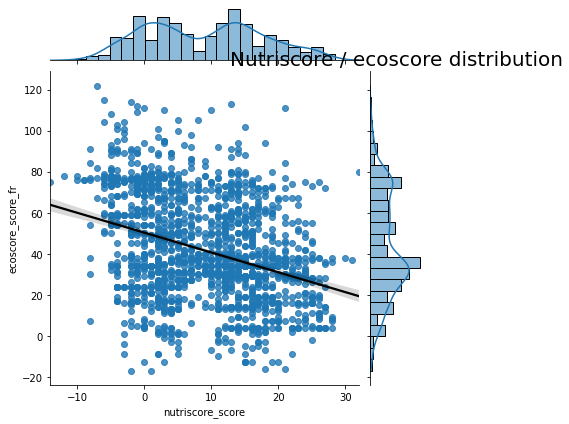

In [8]:
fig = plt.figure(figsize=(10, 6))

sns.jointplot(x="nutriscore_score", y="ecoscore_score_fr", data=data.iloc[::1], kind="kde")
sns.jointplot(x="nutriscore_score", y="ecoscore_score_fr", data=data.iloc[::10], kind="reg", color=None, joint_kws={"line_kws": {'color':'black'}})

plt.title("Nutriscore / ecoscore distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore", size=16)
plt.ylabel("Ecoscore", size=16)
plt.show()

BOXPLOT !

***
# 7 Nutriscore / countries disribution

In [9]:
data.iloc[10:].countries_en.head(20)

210       United States
93222     United States
59572     United States
43521     United States
72905     United States
14289     United States
74750     United States
63947     United States
30673     United States
69763     United States
42206     United States
42296     United States
94322     United States
33515     United States
26789     United States
8736      United States
93738     United States
31920    United Kingdom
90448            Canada
90210     United States
Name: countries_en, dtype: object

The feature "countries_en" is in reality a list, as we can see at index 47266: France,United Kingdom.  
We will choose to keep only the last country in this list for each row.

In [10]:
def keep_last_country(row):
    cotr = row["countries_en"]
    splt = cotr.split(",")
    row["countries_en"] = splt[-1]
    return row

data = data[data.countries_en.notna()].apply(lambda row: keep_last_country(row), axis=1)

In [11]:
data.iloc[10:].countries_en.head(20)

210       United States
93222     United States
59572     United States
43521     United States
72905     United States
14289     United States
74750     United States
63947     United States
30673     United States
69763     United States
42206     United States
42296     United States
94322     United States
33515     United States
26789     United States
8736      United States
93738     United States
31920    United Kingdom
90448            Canada
90210     United States
Name: countries_en, dtype: object

Let's see now how the nutriscore is distributed by country.

In [12]:
data_by_countries_nutriscore = data.groupby(["countries_en", "nutriscore_grade"]).nutriscore_grade.agg([len])
data_by_countries_nutriscore

len
countries_en                      nutriscore_grade      
Albania                           e                    1
Albanie                           e                    1
Algeria                           d                    2
                                  e                    2
Allemagne                         d                    1
                                  e                    1
Andorra                           a                    1
                                  b                    1
                                  d                    1
Argentina                         a                    4
                                  b                    6
                                  c                    1
                                  d                    5
                                  e                    3
Australia                         a                   30
                                  b                   17
                                  c                   18
                                  d                   29
                                  e                   14
Austria                           a                   11
                                  b                   12
                                  c                   19
                                  d                   17
                                  e                    5
Belgie                            c                    1
Belgien                           d                    1
Belgique                          a                    2
                                  b                    1
                                  d                    1
Belgium                           a                   69
                                  b                   68
                                  c                  120
                                  d                  126
                                  e                   86
Bolivia                           a                    1
                                  d                    1
                                  e                    2
Bosnia and Herzegovina            d                    3
Brazil                            a                    3
                                  b                    3
                                  c                    2
                                  d                    2
                                  e                    2
Bulgaria                          b                    3
                                  d                    3
                                  e                    5
Cameroon                          a                    1
Canada                            a                   35
                                  b                   36
                                  c                   34
                                  d                   55
                                  e                   20
Chile                             c                    1
                                  d                    3
China                             c                    1
                                  e                    1
Colombia                          a                    9
                                  b                    5
                                  c                    5
                                  d                    5
                                  e                    7
Croatia                           a                    1
                                  d                    1
Cyprus                            b                    1
                                  c                    1
Czech Republic                    a                    9
                                  b                    9
                                  c                    7
                                  d                    6
      

In [13]:
data_by_countries_nutriscore = data_by_countries_nutriscore.reset_index()
data_by_countries_nutriscore.head()

,countries_en,nutriscore_grade,len
0,Albania,e,1
1,Albanie,e,1
2,Algeria,d,2
3,Algeria,e,2
4,Allemagne,d,1


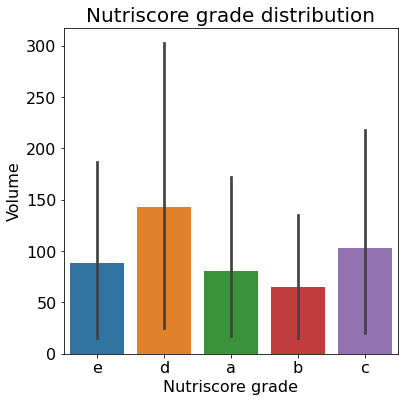

In [14]:
plt.figure(figsize=(6,6))

sns.barplot(x=data_by_countries_nutriscore["nutriscore_grade"], y=data_by_countries_nutriscore["len"])

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

In [15]:
nutriscore_distrib_per_country = data_by_countries_nutriscore.loc[data_by_countries_nutriscore.countries_en.isin(["France", "Germany", "Belgium", "Canad", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

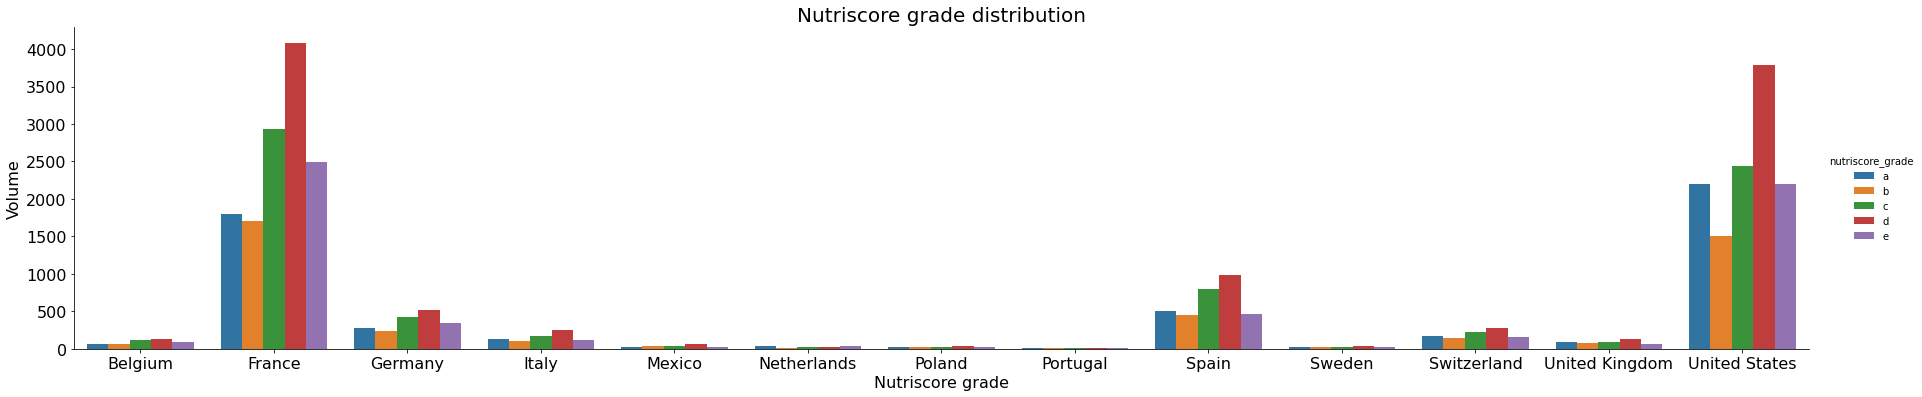

In [16]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="nutriscore_grade", data=nutriscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# 8 Ecoscore / countries distribution

Let's see now how the ecoscore is distributed by country.

In [17]:
data_by_countries_ecoscore = data.groupby(["countries_en", "ecoscore_grade_fr"]).ecoscore_grade_fr.agg([len])
data_by_countries_ecoscore

len
countries_en                      ecoscore_grade_fr      
Albania                           c                     1
                                  d                     1
Algeria                           b                     2
                                  c                     7
                                  d                     5
                                  e                     1
Allemagne                         d                     1
Andorra                           b                     1
                                  d                     2
Argentina                         b                    11
                                  c                     5
                                  d                    16
                                  e                     6
Australia                         a                     6
                                  b                    31
                                  c                    22
                                  d                    27
                                  e                    10
Austria                           a                     3
                                  b                    11
                                  c                    13
                                  d                    10
                                  e                     6
Belarus                           d                     1
Belgien                           b                     1
Belgium                           a                    11
                                  b                   108
                                  c                    64
                                  d                   158
                                  e                    88
Bolivia                           b                     3
                                  d                     2
Bosnia and Herzegovina            b                     1
                                  d                     1
Brazil                            b                     2
                                  c                     4
                                  d                     5
                                  e                     3
Bulgaria                          b                     1
                                  c                     3
                                  d                     3
                                  e                     2
Cameroon                          c                     1
Canada                            a                     5
                                  b                    47
                                  c                    39
                                  d                    43
                                  e                    26
Chile                             b                     3
                                  d                     3
                                  e                     1
China                             c                     1
                                  d                     1
Colombia                          b                     8
                                  c                     9
                                  d                     7
                                  e                     6
Costa Rica                        c                     1
                                  d                     1
Croatia                           a                     1
                                  b                     1
                                  d                     1
Cuba                              e                     1
Cyprus                            c                     1
                                  d                     1
Czech Republic                    a                     2
                                  b                     7
                                  c                 

In [18]:
data_by_countries_ecoscore = data_by_countries_ecoscore.reset_index()
data_by_countries_ecoscore.head()

,countries_en,ecoscore_grade_fr,len
0,Albania,c,1
1,Albania,d,1
2,Algeria,b,2
3,Algeria,c,7
4,Algeria,d,5


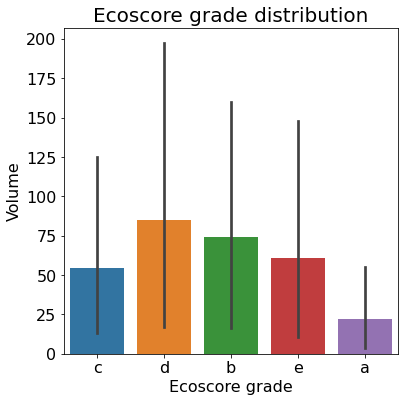

In [19]:
plt.figure(figsize=(6,6))

sns.barplot(x=data_by_countries_ecoscore["ecoscore_grade_fr"], y=data_by_countries_ecoscore["len"])

plt.title("Ecoscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Ecoscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

In [20]:
ecoscore_distrib_per_country = data_by_countries_ecoscore.loc[data_by_countries_ecoscore.countries_en.isin(["France", "Germany", "Belgium", "Canad", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

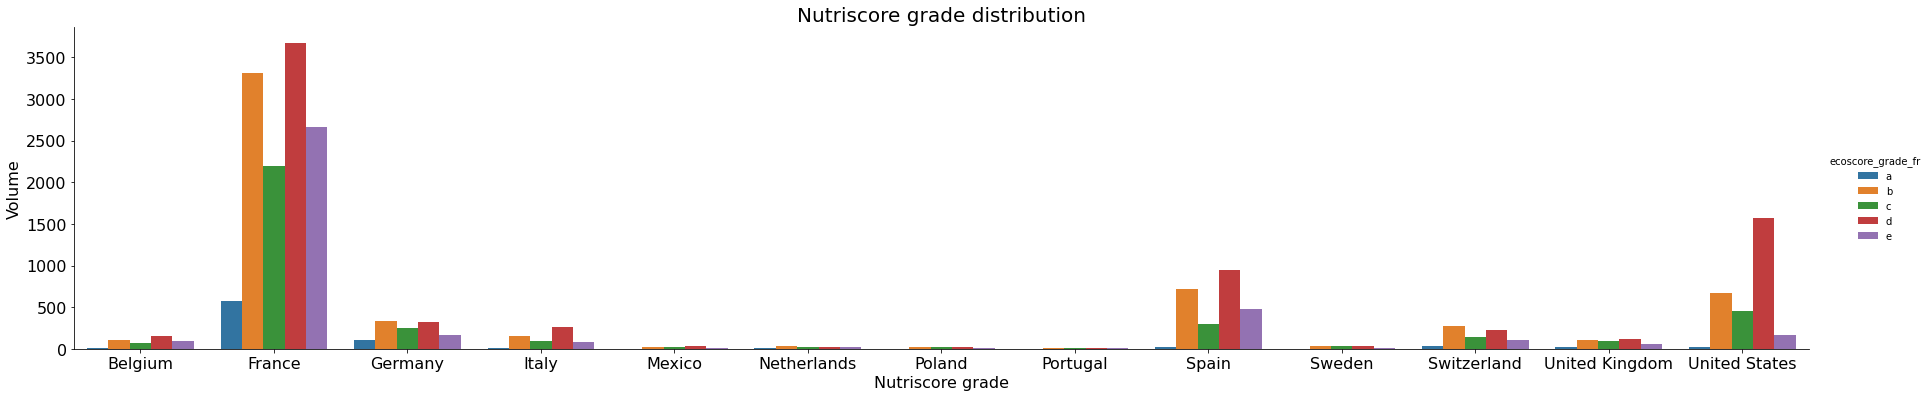

In [21]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="ecoscore_grade_fr", data=ecoscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# ---

## categorical to numerical transformation test

In [22]:
data["ecoscore_CAT"] = data["ecoscore_grade_fr"].astype("category").cat.codes

In [23]:
data["nutriscore_CAT"] = data["nutriscore_grade"].astype("category").cat.codes

In [24]:
data.loc[:, ["ecoscore_CAT", "nutriscore_CAT"]].head()

,ecoscore_CAT,nutriscore_CAT
86295,-1,-1
328,-1,-1
16717,-1,2
46618,-1,-1
47547,-1,3


## correlation: nutriscore/ecoscore/countries

In [25]:
data["countries_NUM"] = data["countries_en"].astype("category").cat.codes

In [26]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
86295,181,-1,-1
328,57,-1,-1
16717,182,2,-1
46618,57,-1,-1
47547,182,3,-1


In [27]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
countries_NUM,1.000000,0.141740,-0.098042
nutriscore_CAT,0.141740,1.000000,0.451803
ecoscore_CAT,-0.098042,0.451803,1.000000


## correlation: nutriscore/ecoscore/brands

In [28]:
data["brands_NUM"] = data["brands"].astype('category').cat.codes

In [29]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
86295,15058,-1,-1
328,-1,-1,-1
16717,8694,2,-1
46618,-1,-1,-1
47547,12039,3,-1


In [30]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
brands_NUM,1.000000,0.186306,0.149108
nutriscore_CAT,0.186306,1.000000,0.451803
ecoscore_CAT,0.149108,0.451803,1.000000


## correlation: nutriscore/ecoscore/packaging

In [31]:
data["packaging_NUM"] = data["packaging"].astype("category").cat.codes

In [32]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,-1,2,-1
46618,-1,-1,-1
47547,-1,3,-1


In [33]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
packaging_NUM,1.000000,0.173721,0.178737
nutriscore_CAT,0.173721,1.000000,0.451803
ecoscore_CAT,0.178737,0.451803,1.000000


## correlation: nutriscore/ecoscore/categories_en

In [34]:
data["categories_en_NUM"] = data["categories_en"].astype("category").cat.codes

In [35]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,3830,2,-1
46618,-1,-1,-1
47547,7844,3,-1


In [36]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
categories_en_NUM,1.000000,0.600126,0.429065
nutriscore_CAT,0.600126,1.000000,0.451803
ecoscore_CAT,0.429065,0.451803,1.000000


## correlation: nutriscore/ecoscore/labels_en

In [37]:
data["labels_en_NUM"] = data["labels_en"].astype("category").cat.codes

In [38]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,-1,2,-1
46618,-1,-1,-1
47547,-1,3,-1


In [39]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
labels_en_NUM,1.000000,0.114378,0.139615
nutriscore_CAT,0.114378,1.000000,0.451803
ecoscore_CAT,0.139615,0.451803,1.000000


## correlation: nutriscore/ecoscore/serving_quantity

In [40]:
data["serving_quantity_NUM"] = data["serving_quantity"].astype("category").cat.codes

In [41]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,130,2,-1
46618,-1,-1,-1
47547,289,3,-1


In [42]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
serving_quantity_NUM,1.000000,0.281169,0.001210
nutriscore_CAT,0.281169,1.000000,0.451803
ecoscore_CAT,0.001210,0.451803,1.000000


## correlation: nutriscore/ecoscore/pnns_groups_1/pnns_groups_2

In [43]:
data["pnns_groups_1_NUM"] = data["pnns_groups_1"].astype("category").cat.codes

In [44]:
data["pnns_groups_2_NUM"] = data["pnns_groups_2"].astype("category").cat.codes

In [45]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_2_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,pnns_groups_1_NUM,pnns_groups_2_NUM,nutriscore_CAT,ecoscore_CAT
86295,10,39,-1,-1
328,10,39,-1,-1
16717,1,27,2,-1
46618,10,39,-1,-1
47547,9,34,3,-1


In [46]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_1_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,pnns_groups_1_NUM,pnns_groups_1_NUM,nutriscore_CAT,ecoscore_CAT
pnns_groups_1_NUM,1.000000,1.000000,-0.391910,-0.404109
pnns_groups_1_NUM,1.000000,1.000000,-0.391910,-0.404109
nutriscore_CAT,-0.391910,-0.391910,1.000000,0.451803
ecoscore_CAT,-0.404109,-0.404109,0.451803,1.000000


## correlation: nutriscore/ecoscore/brand_owner

In [47]:
data["brand_owner_NUM"] = data["brand_owner"].astype("category").cat.codes

In [48]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,4427,2,-1
46618,-1,-1,-1
47547,2725,3,-1


In [49]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
brand_owner_NUM,1.000000,0.294887,-0.046232
nutriscore_CAT,0.294887,1.000000,0.451803
ecoscore_CAT,-0.046232,0.451803,1.000000


## correlation: nutriscore/ecoscore/nova_group

In [50]:
data["nova_group_NUM"] = data["nova_group"].astype("category").cat.codes

In [51]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,3,2,-1
46618,-1,-1,-1
47547,3,3,-1


In [52]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
nova_group_NUM,1.000000,0.486866,0.139308
nutriscore_CAT,0.486866,1.000000,0.451803
ecoscore_CAT,0.139308,0.451803,1.000000


## correlation: nutriscore/ecoscore/additives_en

In [53]:
data["additives_en_NUM"] = data["additives_en"].astype("category").cat.codes

In [54]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
86295,-1,-1,-1
328,-1,-1,-1
16717,8571,2,-1
46618,-1,-1,-1
47547,4291,3,-1


In [55]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
additives_en_NUM,1.000000,0.347244,0.078472
nutriscore_CAT,0.347244,1.000000,0.451803
ecoscore_CAT,0.078472,0.451803,1.000000


## corr recap

In [56]:
corr = data.corr()

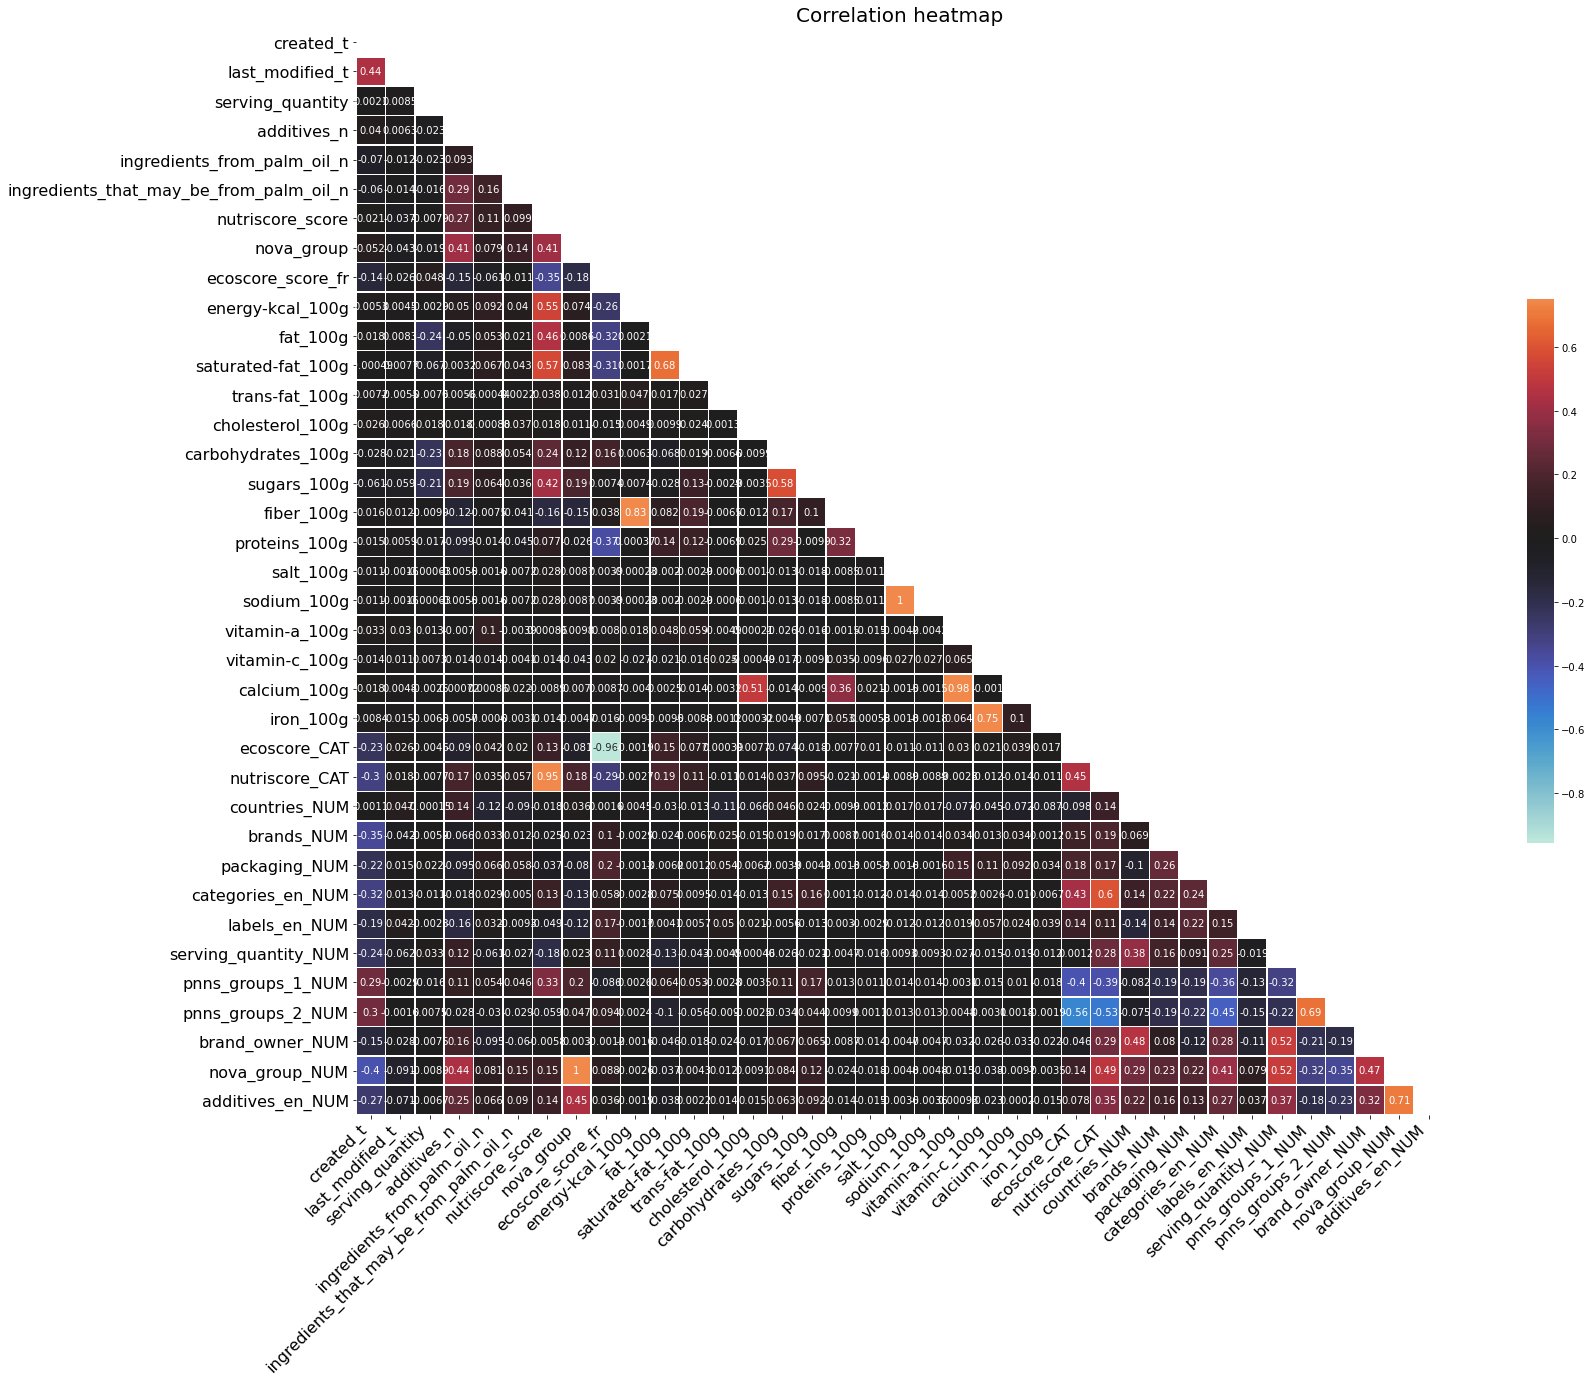

In [57]:
plt.figure(figsize=(30, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(data=corr, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

boxplot, barplot, pie chart, histogramme, scatter plot
Les distributions observées sont correctement caractérisées (uni, bi, multi-modale).
 La définition mathématique de la corrélation et les hypothèses sous-jacentes ont été expliquées
Les éventuelles valeurs aberrantes ont été mises en évidence. Une solution est proposée (elle doit être justifiée si plusieurs choix sont possibles).
La définition des quantiles est correctement maîtrisées.